In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)
# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

Num GPUs Available:  1


In [2]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, print_stats=True ,return_kde=False):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.

    :param data: Dataset to calculate the KDE of.
    :param bins: Number of bins to use for the KDE.
    :param plot_kde: Boolean to indicate whether to plot the KDE.
    :param print_stats: Boolean to indicate whether to print the mean and standard deviation of the KDE.
    :param return_kde: Boolean to indicate whether to return the KDE and bin centers.

    :return: If return_kde is True, the KDE and bin centers are returned.
    """


    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)
        kde[i, :] = kde_func(bin_centers[i])

    if plot_kde:
        plt.figure(figsize=(5, 5))
        plt.plot(
            bin_centers[0],
            kde[0],
            color=plt_colors[0],
            label="black panel",
        )
        plt.plot(
            bin_centers[1],
            kde[1],
            color=plt_colors[1],
            label="silver panel",
        )
        plt.plot(
            bin_centers[2],
            kde[2],
            color=plt_colors[2],
            label="black chassis",
        )
        plt.plot(
            bin_centers[3],
            kde[3],
            color=plt_colors[3],
            label="silver chassis",
        )
        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel("Probability density $1/(^\circ$C)")
        plt.title("Kernel density estimate of the errors")
        plt.legend()
        plt.grid()
        plt.show()

    if print_stats:
        print("Black panel:")
        print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
        print("Silver panel:")
        print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
        print("Black chassis:")
        print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
        print("Silver chassis:")
        print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")

        print("\n")
        print("Probability of error within 1 degC:")
        print(f"Black panel: {np.trapz(kde[0][np.abs(bin_centers[0]) <= 1], bin_centers[0][np.abs(bin_centers[0]) <= 1]):.2f}")
        print(f"Silver panel: {np.trapz(kde[1][np.abs(bin_centers[1]) <= 1], bin_centers[1][np.abs(bin_centers[1]) <= 1]):.2f}")
        print(f"Black chassis: {np.trapz(kde[2][np.abs(bin_centers[2]) <= 1], bin_centers[2][np.abs(bin_centers[2]) <= 1]):.2f}")
        print(f"Silver chassis: {np.trapz(kde[3][np.abs(bin_centers[3]) <= 1], bin_centers[3][np.abs(bin_centers[3]) <= 1]):.2f}")


    if return_kde:
        return kde, bin_centers

In [3]:
# Loading the data
telem_path = r"../telemetry-files/funcube-1/funcube-1-telemetry-2016-02-10.h5"
telem_df = pd.read_hdf(
    telem_path,
    "telem",
)

# Adding illumination data:
for i, row in telem_df.iterrows():
    telem_df.loc[i, "illumination"] = 1 if row["theta_T (deg)"] < 360 * (1 - row["fe"]) else 0

# Reordering columns to have illumination after theta_T (deg):
illum_col = telem_df["illumination"].to_numpy()
telem_df = telem_df.drop("illumination", axis=1)
telem_df.insert(loc=6, column="illumination", value=illum_col)

telem_df.head()

time (utc)     time (jd)  beta (deg)        fe  theta (deg)  \
0  2016-02-04 00:00:00.000  2.457422e+06   43.419578  0.314142   287.512192   
1  2016-02-04 00:01:00.000  2.457423e+06   43.419238  0.313883   291.258857   
2  2016-02-04 00:02:00.000  2.457423e+06   43.418972  0.313594   295.003917   
3  2016-02-04 00:03:00.000  2.457423e+06   43.418786  0.313277   298.747190   
4  2016-02-04 00:04:00.000  2.457423e+06   43.418684  0.312933   302.488507   

   theta_T (deg)  illumination  black chassis temperature (deg C)  \
0      50.966681           1.0                               1.23   
1      54.759942           1.0                               1.47   
2      58.556932           1.0                               0.00   
3      62.357285           1.0                               1.68   
4      66.160507           1.0                               3.65   

   silver chassis temperature (deg C)  black panel temperature (deg C)  \
0                               -0.85                            -2.10   
1                                1.17                             2.75   
2                                2.44                             7.00   
3                                1.81                             4.38   
4                                2.77                             6.23   

   silver panel temperature (deg C)  solar panel +X temperature (deg C)  \
0                              2.23                                3.39   
1                              5.04                                0.69   
2                              8.09                               -1.80   
3                              5.67                                2.97   
4                              6.31                                2.14   

   solar panel -X temperature (deg C)  solar panel +Y temperature (deg C)  \
0                               -2.41                               -1.40   
1                                0.92                                2.75   
2                                3.84                               -0.57   
3                                0.50                               -1.40   
4                                0.50                                3.79   

   solar panel -Y temperature (deg C)  
0                                0.43  
1                               -2.91  
2                                1.89  
3                                3.77  
4                                0.22

In [4]:
def normalize_datasets(df, min_temp, max_temp):
    df = df.copy()
    df.iloc[:, 7:] = (
        df.iloc[:, 7:] - min_temp
    ) / (max_temp - min_temp)

    return df


def window_data_base(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(
        columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue

        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i +
                                                      window_size - 1, "illumination"]
        window_df.loc[i,
                      "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i,
                      "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i,
                      "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i,
                      "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna().reset_index(drop=True)

    if return_numpy:
        x_data = np.empty(
            shape=(len(window_df), window_size, 1), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.iloc[1:window_size + 1]
            y_data[i, :] = row.iloc[window_size + 1:]

        return window_df, x_data, y_data

    return window_df


def create_model(layers, optimizer, loss_function, metric_function, input_shape=(None, 1), output_shape=4):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    recommended_device = "/GPU:0"
    for i, layer in enumerate(layers):
        if layer.get("type") == "LSTM":
            if i < len(layers) - 1:
                if layers[i + 1].get("type") == "LSTM":
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=True,
                        )
                    )
                else:
                    model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
            else:
                model.add(
                    tf.keras.layers.LSTM(
                        layer.get("units"),
                        activation=layer.get("activation"),
                        return_sequences=False,
                    )
                )
            if layer.get("activation") != "tanh":
                recommended_device = "/CPU:0"
        elif layer.get("type") == "Dense":
            model.add(
                tf.keras.layers.Dense(
                    layer.get("units"), activation=layer.get("activation"),
                )
            )
        else:
            raise ValueError("Invalid layer type")
    model.add(tf.keras.layers.Dense(output_shape, activation="linear"))

    model.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=[metric_function],
    )
    return model, recommended_device

In [5]:
# Processing the data to remove constant rows and adding illumination data:
telem_processed_df = telem_df.copy()
prev_row = telem_processed_df.loc[0]

for i, row in telem_processed_df.iterrows():
    if i == 0:
        continue
    # Check for same temperature values
    if row.loc[
        "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"
    ].equals(
        prev_row.loc[
            "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"
        ]
    ):
        telem_processed_df.drop(i, inplace=True)
        continue
    # Check for same time
    if (
        row.loc["time (utc)"]
        == prev_row.loc["time (utc)"]
    ):
        telem_processed_df.drop(i, inplace=True)
        continue

    prev_row = row

telem_processed_df = (
    telem_processed_df.reset_index(drop=True)
)

In [6]:
# Splitting the data into training and testing sets
train_df = telem_processed_df[:int(0.8 * len(telem_processed_df))].copy()
test_df = telem_processed_df[int(
    0.8 * len(telem_processed_df)):].copy().reset_index(drop=True)

# Normalizing the data
min_temp = train_df.iloc[:, 7:].min().min()
max_temp = train_df.iloc[:, 7:].max().max()

train_norm_df = normalize_datasets(train_df, min_temp, max_temp)
test_norm_df = normalize_datasets(test_df, min_temp, max_temp)

In [7]:
def plot_model(theta_T_vals, y_data, y_single_pred=None, y_auto_pred=None, plt_title=None, limit_axis=True, labels=None):
    if labels is None:
        labels = ["Data", "Single-step prediction", "Auto-regressive prediction"]

    base_alpha = 0.65

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    if y_single_pred is not None:
        if labels is not None:
            label = labels[1]
        else:
            label = "Single-step prediction"
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 0],
            label=labels[1],
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        if labels is not None:
            label = labels[2]
        else:
            label = "Auto-regressive prediction"
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 0],
            label=labels[2],
            color=plt_colors[2],
        )
    plt.plot(
        theta_T_vals,
        y_data[:, 0],
        label=labels[0],
        color=plt_colors[0],
        linestyle="--",
        alpha=base_alpha,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Black chassis")

    plt.subplot(2, 2, 2)

    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 1],
            label=labels[1],
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 1],
            label=labels[2],
            color=plt_colors[2],
        )
    plt.plot(
        theta_T_vals,
        y_data[:, 1],
        label=labels[0],
        color=plt_colors[0],
        linestyle="--",
        alpha=base_alpha,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Silver chassis")

    plt.subplot(2, 2, 3)
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 2],
            label=labels[1],
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 2],
            label=labels[2],
            color=plt_colors[2],
        )
    plt.plot(
        theta_T_vals,
        y_data[:, 2],
        label=labels[0],
        color=plt_colors[0],
        linestyle="--",
        alpha=base_alpha,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Black panel")

    plt.subplot(2, 2, 4)
    if y_single_pred is not None:
        plt.plot(
            theta_T_vals,
            y_single_pred[:, 3],
            label=labels[1],
            color=plt_colors[1],
        )
    if y_auto_pred is not None:
        plt.plot(
            theta_T_vals,
            y_auto_pred[:, 3],
            label=labels[2],
            color=plt_colors[2],
        )
    plt.plot(
        theta_T_vals,
        y_data[:, 3],
        label=labels[0],
        color=plt_colors[0],
        linestyle="--",
        alpha=base_alpha,
    )
    plt.xlabel(r"$\theta_T\;(^\circ)$")
    plt.ylabel(r"$Temperature\;(^\circ C)$")
    if limit_axis:
        plt.xlim([0, 360])
        plt.ylim([-15, 30])
    plt.legend()
    plt.grid()
    plt.title("Silver panel")

    if plt_title is not None:
        plt.suptitle(plt_title)
    plt.show()
    plt.close()

In [8]:
# Orbit with known anomaly:
anomaly_df = telem_df.loc[374:571].copy().reset_index(drop=True)

# Normalizing data:
anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] = (
    anomaly_df.loc[:, "black chassis temperature (deg C)":"solar panel -Y temperature (deg C)"] - min_temp
) / (max_temp - min_temp)

# Remove duplicate theta_T values:
anomaly_df = anomaly_df.drop_duplicates(subset="theta_T (deg)", keep="last").reset_index(drop=True)


def create_artificial_anomaly(window_size, anomaly_black_chassis=False, anomaly_silver_chassis=False, anomaly_black_panel=False, anomaly_silver_panel=False):
    artificial_anomaly_df = pd.DataFrame(
        columns=[
            "theta_T (deg)",
            "illumination",
            "black chassis temperature (deg C)",
            "silver chassis temperature (deg C)",
            "black panel temperature (deg C)",
            "silver panel temperature (deg C)",
        ],
    )
    if window_size < 94:
        orbit_0_end = 94
        orbit_0_start = orbit_0_end - window_size
        orbit_1_start = 94
        orbit_1_end = 191
    else:
        orbit_0_end = 94 + (window_size - 94)
        orbit_0_start = 0
        orbit_1_start = 94 + (window_size - 94)
        orbit_1_end = 191 + (window_size - 94)
    anomaly_df_temp_0 = anomaly_df[100-window_size:99].copy().reset_index(drop=True)
    anomaly_df_temp_1 = anomaly_df[100:].copy().reset_index(drop=True)
    
    artificial_anomaly_df["theta_T (deg)"] = test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end]
    artificial_anomaly_df["illumination"] = test_norm_df["illumination"][orbit_0_start:orbit_0_end]
    # One orbit before anomaly:
    if anomaly_black_chassis:
        black_chassis_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["black chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["black chassis temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )
    
    if anomaly_silver_chassis:
        silver_chassis_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["silver chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["silver chassis temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_black_panel:
        black_panel_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["black panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["black panel temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_panel:
        silver_panel_interp = interp1d(
            anomaly_df_temp_0["theta_T (deg)"],
            anomaly_df_temp_0["silver panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_0_start:orbit_0_end],
            test_norm_df["silver panel temperature (deg C)"][orbit_0_start:orbit_0_end],
            kind="cubic",
            fill_value="extrapolate",
        )


    artificial_anomaly_df["black chassis temperature (deg C)"] = black_chassis_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["silver chassis temperature (deg C)"] = silver_chassis_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["black panel temperature (deg C)"] = black_panel_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )
    artificial_anomaly_df["silver panel temperature (deg C)"] = silver_panel_interp(
        artificial_anomaly_df["theta_T (deg)"]
    )

    # Anomaly orbit:
    if anomaly_black_chassis:
        black_chassis_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["black chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["black chassis temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_chassis:
        silver_chassis_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["silver chassis temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_chassis_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["silver chassis temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_black_panel:
        black_panel_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["black panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        black_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["black panel temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    if anomaly_silver_panel:
        silver_panel_interp = interp1d(
            anomaly_df_temp_1["theta_T (deg)"],
            anomaly_df_temp_1["silver panel temperature (deg C)"],
            kind="cubic",
            fill_value="extrapolate",
        )
    else:
        silver_panel_interp = interp1d(
            test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end],
            test_norm_df["silver panel temperature (deg C)"][orbit_1_start:orbit_1_end],
            kind="cubic",
            fill_value="extrapolate",
        )

    artificial_anomaly_df = artificial_anomaly_df.reset_index(drop=True)

    theta_T_anomaly_orbit = test_norm_df["theta_T (deg)"][orbit_1_start:orbit_1_end].to_numpy()
    illumination_anomaly_orbit = test_norm_df["illumination"][orbit_1_start:orbit_1_end].to_numpy()
    for i in range(len(theta_T_anomaly_orbit)):
        artificial_anomaly_df.loc[window_size + i, "theta_T (deg)"] = theta_T_anomaly_orbit[i]
        artificial_anomaly_df.loc[window_size + i, "illumination"] = illumination_anomaly_orbit[i]
        artificial_anomaly_df.loc[window_size + i, "black chassis temperature (deg C)"] = black_chassis_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "silver chassis temperature (deg C)"] = silver_chassis_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "black panel temperature (deg C)"] = black_panel_interp(
            theta_T_anomaly_orbit[i]
        )
        artificial_anomaly_df.loc[window_size + i, "silver panel temperature (deg C)"] = silver_panel_interp(
            theta_T_anomaly_orbit[i]
        )   

    return artificial_anomaly_df

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         264192    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

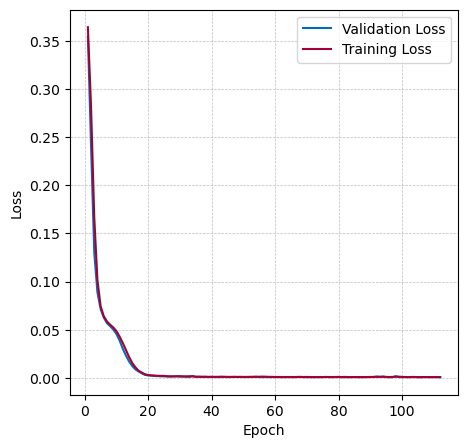

In [9]:
train_97_df, x_train_97, y_train_97 = window_data_base(train_norm_df, 97, return_numpy=True)
test_97_df, x_test_97, y_test_97 = window_data_base(test_norm_df, 97, return_numpy=True)

model_base_layers = np.empty(shape=(7), dtype=dict,)
model_base_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
model_base_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
model_base_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
model_base_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
model_base_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

model_base, recommended_device = create_model(
    model_base_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
)

model_base.summary()

with tf.device(recommended_device):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
    )

    history_97 = model_base.fit(
        x_train_97,
        y_train_97,
        epochs=250,
        validation_data=(x_test_97, y_test_97),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97.history["loss"]), len(history_97.history["loss"])),
    history_97.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

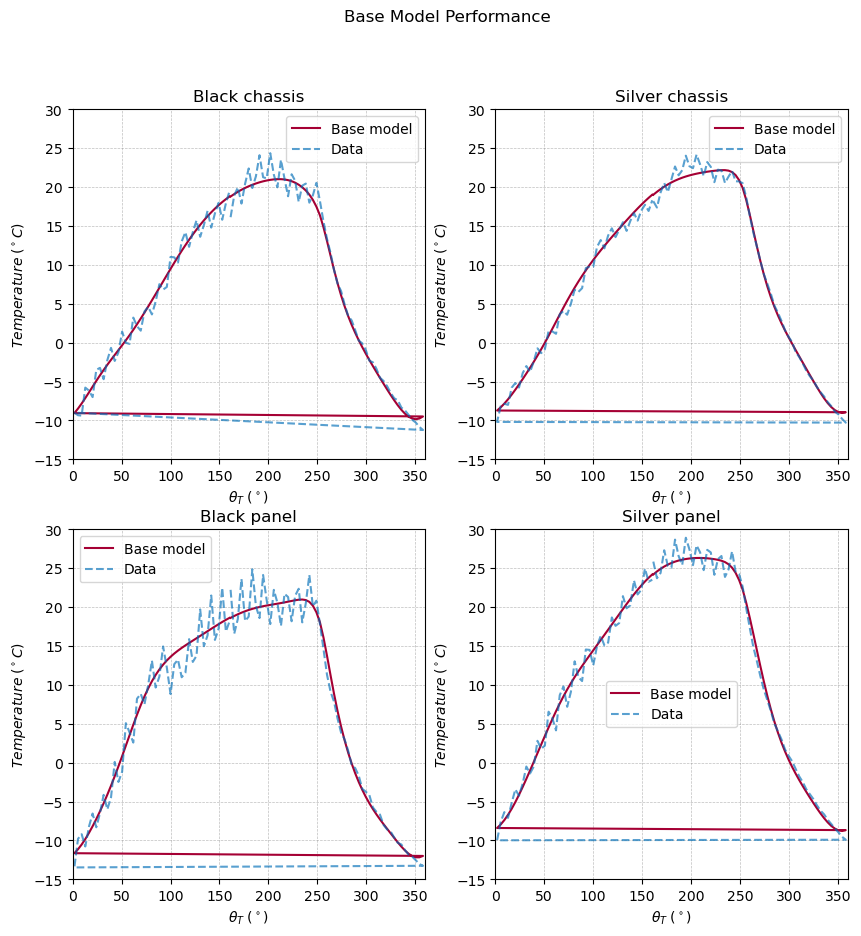

In [10]:
y_pred_base = model_base.predict(x_test_97, verbose=0)

plot_model(
    test_97_df["theta_T"][13:],
    y_test_97[13:] * (max_temp - min_temp) + min_temp,
    y_pred_base[13:] * (max_temp - min_temp) + min_temp,
    plt_title="Base Model Performance",
    labels=["Data", "Base model", None]
)

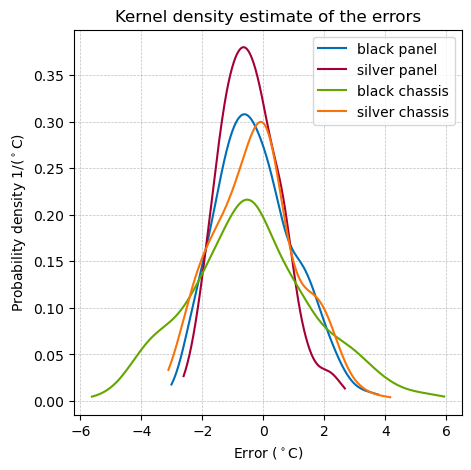

Black panel:
Mean: -0.24 degC Std: 1.26 degC (area: 0.99)
Silver panel:
Mean: -0.43 degC Std: 0.99 degC (area: 0.99)
Black chassis:
Mean: -0.41 degC Std: 2.02 degC (area: 1.00)
Silver chassis:
Mean: -0.23 degC Std: 1.36 degC (area: 0.99)


Probability of error within 1 degC:
Black panel: 0.51
Silver panel: 0.59
Black chassis: 0.36
Silver chassis: 0.50


In [11]:
# Residual models:
y_pred_base = model_base.predict(x_train_97, verbose=0)
y_res = (y_train_97 - y_pred_base) * (max_temp - min_temp)

min_temp_res = np.min(y_res)
max_temp_res = np.max(y_res)

# Plotting probability density function:
kde(y_res)


In [12]:
def window_data_res_1(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["input black chassis temp"],
        ["input silver chassis temp"],
        ["input black panel temp"],
        ["input silver panel temp"],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "input black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "input silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "input black panel temp"] = df["black panel temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "input silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna(how="all").reset_index(drop=True)

    x_pred = window_df.iloc[:, 1:window_size + 1].to_numpy(dtype=np.float64)
    x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
    y_pred = model_base.predict(x_pred, verbose=0)

    window_df["predicted black chassis temp"] = y_pred[:, 0]
    window_df["predicted silver chassis temp"] = y_pred[:, 1]
    window_df["predicted black panel temp"] = y_pred[:, 2]
    window_df["predicted silver panel temp"] = y_pred[:, 3]

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 9), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["predicted black chassis temp"]
            x_data[i, 2] = row["predicted silver chassis temp"]
            x_data[i, 3] = row["predicted black panel temp"]
            x_data[i, 4] = row["predicted silver panel temp"]
            x_data[i, 5] = row["input black chassis temp"]
            x_data[i, 6] = row["input silver chassis temp"]
            x_data[i, 7] = row["input black panel temp"]
            x_data[i, 8] = row["input silver panel temp"]

            y_data[i, 0] = (row["black chassis temp"] - row["predicted black chassis temp"]) * (max_temp - min_temp)
            y_data[i, 1] = (row["silver chassis temp"] - row["predicted silver chassis temp"]) * (max_temp - min_temp)
            y_data[i, 2] = (row["black panel temp"] - row["predicted black panel temp"]) * (max_temp - min_temp)
            y_data[i, 3] = (row["silver panel temp"] - row["predicted silver panel temp"]) * (max_temp - min_temp)

        return window_df, x_data, y_data

    return window_df


Epoch 1/5000
11/11 [==============================] - 1s 22ms/step - loss: 2.2309 - mean_absolute_error: 1.1661 - val_loss: 1.8351 - val_mean_absolute_error: 1.0122
Epoch 2/5000
11/11 [==============================] - 0s 7ms/step - loss: 2.2229 - mean_absolute_error: 1.1631 - val_loss: 1.8352 - val_mean_absolute_error: 1.0117
Epoch 3/5000
11/11 [==============================] - 0s 8ms/step - loss: 2.2140 - mean_absolute_error: 1.1597 - val_loss: 1.8366 - val_mean_absolute_error: 1.0114
Epoch 4/5000
11/11 [==============================] - 0s 6ms/step - loss: 2.2042 - mean_absolute_error: 1.1562 - val_loss: 1.8386 - val_mean_absolute_error: 1.0120
Epoch 5/5000
11/11 [==============================] - 0s 7ms/step - loss: 2.1954 - mean_absolute_error: 1.1530 - val_loss: 1.8409 - val_mean_absolute_error: 1.0126
Epoch 6/5000
11/11 [==============================] - 0s 6ms/step - loss: 2.1897 - mean_absolute_error: 1.1508 - val_loss: 1.8452 - val_mean_absolute_error: 1.0138
Epoch 7/5000
11

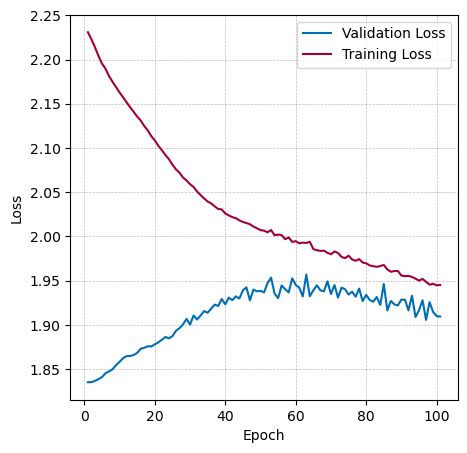

In [13]:
train_97_res_df_1, x_train_97_res_1, y_train_97_res_1 = window_data_res_1(train_norm_df, 97, return_numpy=True, check_continuity=True)
test_97_res_df_1, x_test_97_res_1, y_test_97_res_1 = window_data_res_1(test_norm_df, 97, return_numpy=True, check_continuity=True)

# Create residual correction model
model_res_1 = tf.keras.Sequential()
model_res_1.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(9,)))
model_res_1.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_1.add(tf.keras.layers.Dense(4, activation="linear"))

model_res_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_1.fit(
    x_train_97_res_1,
    y_train_97_res_1,
    epochs=5000,
    validation_data=(x_test_97_res_1, y_test_97_res_1),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

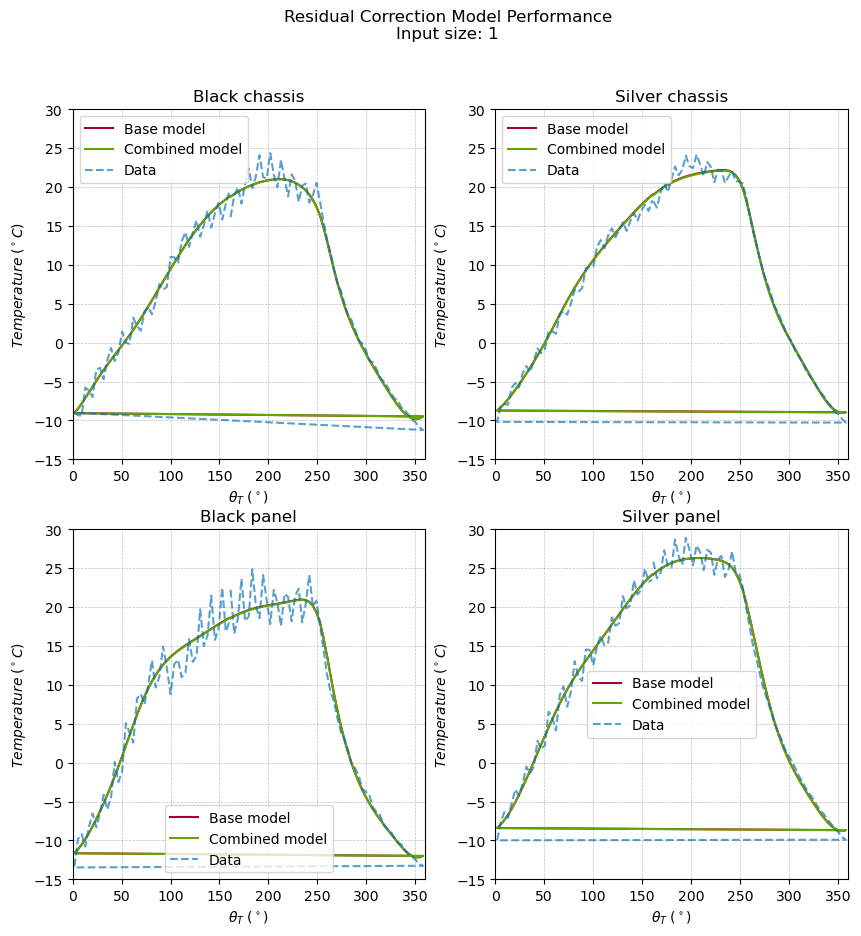

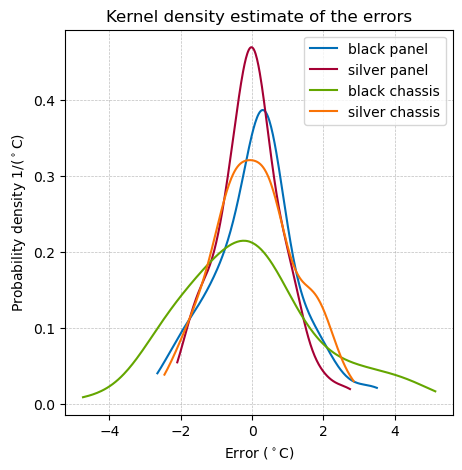

Black panel:
Mean: 0.10 degC Std: 1.21 degC (area: 0.97)
Silver panel:
Mean: -0.04 degC Std: 0.93 degC (area: 0.98)
Black chassis:
Mean: -0.10 degC Std: 1.92 degC (area: 0.98)
Silver chassis:
Mean: 0.10 degC Std: 1.15 degC (area: 0.98)


Probability of error within 1 degC:
Black panel: 0.59
Silver panel: 0.69
Black chassis: 0.39
Silver chassis: 0.57


In [14]:
y_pred_base = model_base.predict(x_test_97, verbose=0)
y_pred_res = model_res_1.predict(x_test_97_res_1, verbose=0)
y_pred_combined = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res

y_res = y_test_97 * (max_temp - min_temp) + min_temp - y_pred_combined

plot_model(
    test_97_df["theta_T"][13:],
    y_test_97[13:] * (max_temp - min_temp) + min_temp,
    y_pred_base[13:] * (max_temp - min_temp) + min_temp,
    y_pred_combined[13:],
    plt_title="Residual Correction Model Performance\nInput size: 1",
    labels=["Data", "Base model", "Combined model"],
)

kde(y_res)

In [ ]:
def window_data_res_val_2(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["input black chassis temp " + str(i) for i in range(2)],
        ["input silver chassis temp " + str(i) for i in range(2)],
        ["input black panel temp " + str(i) for i in range(2)],
        ["input silver panel temp " + str(i) for i in range(2)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "input black chassis temp 0":"input black chassis temp 1"] = df["black chassis temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input silver chassis temp 0":"input silver chassis temp 1"] = df["silver chassis temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input black panel temp 0":"input black panel temp 1"] = df["black panel temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input silver panel temp 0":"input silver panel temp 1"] = df["silver panel temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna(how="all").reset_index(drop=True)

    x_pred = window_df.iloc[:, 1:window_size + 1].to_numpy(dtype=np.float64)
    x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
    y_pred = model_base.predict(x_pred, verbose=0)

    window_df["predicted black chassis temp"] = y_pred[:, 0]
    window_df["predicted silver chassis temp"] = y_pred[:, 1]
    window_df["predicted black panel temp"] = y_pred[:, 2]
    window_df["predicted silver panel temp"] = y_pred[:, 3]

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 25), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["predicted black chassis temp"]
            x_data[i, 2] = row["predicted silver chassis temp"]
            x_data[i, 3] = row["predicted black panel temp"]
            x_data[i, 4] = row["predicted silver panel temp"]
            x_data[i, 5:10] = row["input black chassis temp 0":"input black chassis temp 1"].values
            x_data[i, 10:15] = row["input silver chassis temp 0":"input silver chassis temp 1"].values
            x_data[i, 15:20] = row["input black panel temp 0":"input black panel temp 1"].values
            x_data[i, 20:25] = row["input silver panel temp 0":"input silver panel temp 1"].values

            y_data[i, 0] = (row["black chassis temp"] - row["predicted black chassis temp"]) * (max_temp - min_temp)
            y_data[i, 1] = (row["silver chassis temp"] - row["predicted silver chassis temp"]) * (max_temp - min_temp)
            y_data[i, 2] = (row["black panel temp"] - row["predicted black panel temp"]) * (max_temp - min_temp)
            y_data[i, 3] = (row["silver panel temp"] - row["predicted silver panel temp"]) * (max_temp - min_temp)

        return window_df, x_data, y_data

    return window_df


In [15]:
def window_data_res_2(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["input black chassis temp " + str(i) for i in range(5)],
        ["input silver chassis temp " + str(i) for i in range(5)],
        ["input black panel temp " + str(i) for i in range(5)],
        ["input silver panel temp " + str(i) for i in range(5)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "input black chassis temp 0":"input black chassis temp 4"] = df["black chassis temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input silver chassis temp 0":"input silver chassis temp 4"] = df["silver chassis temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input black panel temp 0":"input black panel temp 4"] = df["black panel temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input silver panel temp 0":"input silver panel temp 4"] = df["silver panel temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna(how="all").reset_index(drop=True)

    x_pred = window_df.iloc[:, 1:window_size + 1].to_numpy(dtype=np.float64)
    x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
    y_pred = model_base.predict(x_pred, verbose=0)

    window_df["predicted black chassis temp"] = y_pred[:, 0]
    window_df["predicted silver chassis temp"] = y_pred[:, 1]
    window_df["predicted black panel temp"] = y_pred[:, 2]
    window_df["predicted silver panel temp"] = y_pred[:, 3]

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 25), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["predicted black chassis temp"]
            x_data[i, 2] = row["predicted silver chassis temp"]
            x_data[i, 3] = row["predicted black panel temp"]
            x_data[i, 4] = row["predicted silver panel temp"]
            x_data[i, 5:10] = row["input black chassis temp 0":"input black chassis temp 4"].values
            x_data[i, 10:15] = row["input silver chassis temp 0":"input silver chassis temp 4"].values
            x_data[i, 15:20] = row["input black panel temp 0":"input black panel temp 4"].values
            x_data[i, 20:25] = row["input silver panel temp 0":"input silver panel temp 4"].values

            y_data[i, 0] = (row["black chassis temp"] - row["predicted black chassis temp"]) * (max_temp - min_temp)
            y_data[i, 1] = (row["silver chassis temp"] - row["predicted silver chassis temp"]) * (max_temp - min_temp)
            y_data[i, 2] = (row["black panel temp"] - row["predicted black panel temp"]) * (max_temp - min_temp)
            y_data[i, 3] = (row["silver panel temp"] - row["predicted silver panel temp"]) * (max_temp - min_temp)

        return window_df, x_data, y_data

    return window_df


Epoch 1/5000
11/11 [==============================] - 1s 24ms/step - loss: 2.2306 - mean_absolute_error: 1.1671 - val_loss: 1.8330 - val_mean_absolute_error: 1.0107
Epoch 2/5000
11/11 [==============================] - 0s 7ms/step - loss: 2.2058 - mean_absolute_error: 1.1578 - val_loss: 1.8373 - val_mean_absolute_error: 1.0087
Epoch 3/5000
11/11 [==============================] - 0s 8ms/step - loss: 2.1818 - mean_absolute_error: 1.1490 - val_loss: 1.8467 - val_mean_absolute_error: 1.0101
Epoch 4/5000
11/11 [==============================] - 0s 8ms/step - loss: 2.1629 - mean_absolute_error: 1.1422 - val_loss: 1.8559 - val_mean_absolute_error: 1.0135
Epoch 5/5000
11/11 [==============================] - 0s 8ms/step - loss: 2.1486 - mean_absolute_error: 1.1357 - val_loss: 1.8617 - val_mean_absolute_error: 1.0165
Epoch 6/5000
11/11 [==============================] - 0s 8ms/step - loss: 2.1409 - mean_absolute_error: 1.1315 - val_loss: 1.8822 - val_mean_absolute_error: 1.0219
Epoch 7/5000
11

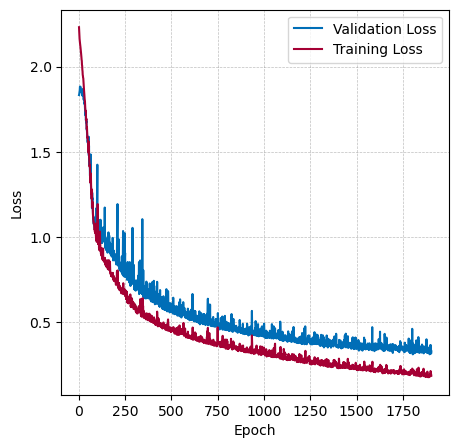

In [16]:
train_97_res_df_2, x_train_97_res_2, y_train_97_res_2 = window_data_res_2(train_norm_df, 97, return_numpy=True, check_continuity=True)
test_97_res_df_2, x_test_97_res_2, y_test_97_res_2 = window_data_res_2(test_norm_df, 97, return_numpy=True, check_continuity=True)

# Create residual correction model
model_res_2 = tf.keras.Sequential()
model_res_2.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(25,)))
model_res_2.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_2.add(tf.keras.layers.Dense(4, activation="linear"))

model_res_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=7.5e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_2.fit(
    x_train_97_res_2,
    y_train_97_res_2,
    epochs=5000,
    validation_data=(x_test_97_res_2, y_test_97_res_2),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

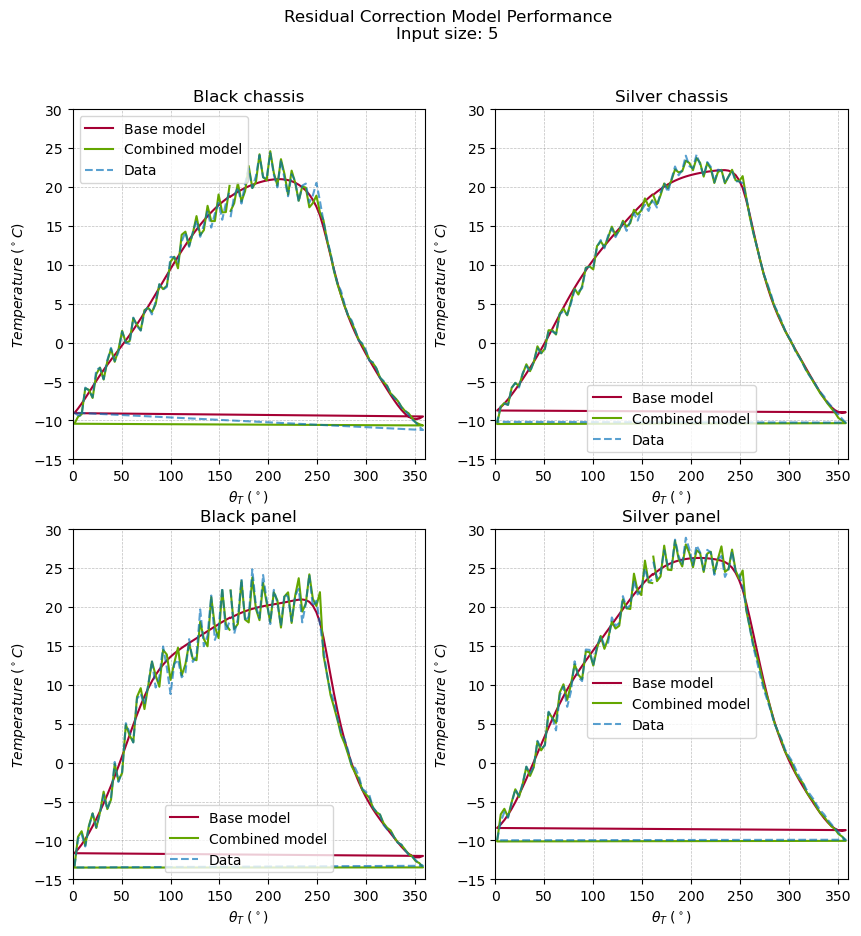

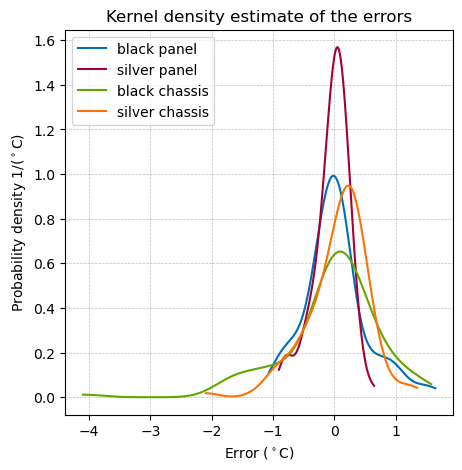

Black panel:
Mean: 0.02 degC Std: 0.51 degC (area: 0.98)
Silver panel:
Mean: -0.04 degC Std: 0.29 degC (area: 0.98)
Black chassis:
Mean: -0.04 degC Std: 0.80 degC (area: 0.98)
Silver chassis:
Mean: 0.06 degC Std: 0.51 degC (area: 0.99)


Probability of error within 1 degC:
Black panel: 0.91
Silver panel: 0.98
Black chassis: 0.79
Silver chassis: 0.93


In [17]:
y_pred_res = model_res_2.predict(x_test_97_res_2, verbose=0)
y_pred_combined = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res

y_res = y_test_97 * (max_temp - min_temp) + min_temp - y_pred_combined

plot_model(
    test_97_df["theta_T"][13:],
    y_test_97[13:] * (max_temp - min_temp) + min_temp,
    y_pred_base[13:] * (max_temp - min_temp) + min_temp,
    y_pred_combined[13:],
    plt_title="Residual Correction Model Performance\nInput size: 5",
    labels=["Data", "Base model", "Combined model"]
)

kde(y_res)

In [18]:
def window_data_res_3(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["input black chassis temp " + str(i) for i in range(10)],
        ["input silver chassis temp " + str(i) for i in range(10)],
        ["input black panel temp " + str(i) for i in range(10)],
        ["input silver panel temp " + str(i) for i in range(10)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "input black chassis temp 0":"input black chassis temp 9"] = df["black chassis temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "input silver chassis temp 0":"input silver chassis temp 9"] = df["silver chassis temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "input black panel temp 0":"input black panel temp 9"] = df["black panel temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "input silver panel temp 0":"input silver panel temp 9"] = df["silver panel temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna(how="all").reset_index(drop=True)

    x_pred = window_df.iloc[:, 1:window_size + 1].to_numpy(dtype=np.float64)
    x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
    y_pred = model_base.predict(x_pred, verbose=0)

    window_df["predicted black chassis temp"] = y_pred[:, 0]
    window_df["predicted silver chassis temp"] = y_pred[:, 1]
    window_df["predicted black panel temp"] = y_pred[:, 2]
    window_df["predicted silver panel temp"] = y_pred[:, 3]

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 45), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["predicted black chassis temp"]
            x_data[i, 2] = row["predicted silver chassis temp"]
            x_data[i, 3] = row["predicted black panel temp"]
            x_data[i, 4] = row["predicted silver panel temp"]
            x_data[i, 5:15] = row["input black chassis temp 0":"input black chassis temp 9"].values
            x_data[i, 15:25] = row["input silver chassis temp 0":"input silver chassis temp 9"].values
            x_data[i, 25:35] = row["input black panel temp 0":"input black panel temp 9"].values
            x_data[i, 35:45] = row["input silver panel temp 0":"input silver panel temp 9"].values

            y_data[i, 0] = (row["black chassis temp"] - row["predicted black chassis temp"]) * (max_temp - min_temp)
            y_data[i, 1] = (row["silver chassis temp"] - row["predicted silver chassis temp"]) * (max_temp - min_temp)
            y_data[i, 2] = (row["black panel temp"] - row["predicted black panel temp"]) * (max_temp - min_temp)
            y_data[i, 3] = (row["silver panel temp"] - row["predicted silver panel temp"]) * (max_temp - min_temp)

        return window_df, x_data, y_data

    return window_df


Epoch 1/5000
11/11 [==============================] - 1s 22ms/step - loss: 2.2285 - mean_absolute_error: 1.1665 - val_loss: 1.8446 - val_mean_absolute_error: 1.0146
Epoch 2/5000
11/11 [==============================] - 0s 6ms/step - loss: 2.2173 - mean_absolute_error: 1.1626 - val_loss: 1.8489 - val_mean_absolute_error: 1.0158
Epoch 3/5000
11/11 [==============================] - 0s 6ms/step - loss: 2.2045 - mean_absolute_error: 1.1572 - val_loss: 1.8538 - val_mean_absolute_error: 1.0178
Epoch 4/5000
11/11 [==============================] - 0s 6ms/step - loss: 2.1914 - mean_absolute_error: 1.1518 - val_loss: 1.8579 - val_mean_absolute_error: 1.0199
Epoch 5/5000
11/11 [==============================] - 0s 6ms/step - loss: 2.1788 - mean_absolute_error: 1.1465 - val_loss: 1.8642 - val_mean_absolute_error: 1.0227
Epoch 6/5000
11/11 [==============================] - 0s 8ms/step - loss: 2.1707 - mean_absolute_error: 1.1429 - val_loss: 1.8747 - val_mean_absolute_error: 1.0271
Epoch 7/5000
11

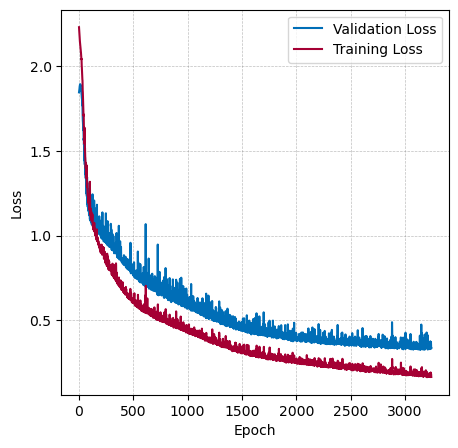

In [19]:
train_97_res_df_3, x_train_97_res_3, y_train_97_res_3 = window_data_res_3(train_norm_df, 97, return_numpy=True, check_continuity=True)
test_97_res_df_3, x_test_97_res_3, y_test_97_res_3 = window_data_res_3(test_norm_df, 97, return_numpy=True, check_continuity=True)

# Create residual correction model
model_res_3 = tf.keras.Sequential()
model_res_3.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(45,)))
model_res_3.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_3.add(tf.keras.layers.Dense(4, activation="linear"))

model_res_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_3.fit(
    x_train_97_res_3,
    y_train_97_res_3,
    epochs=5000,
    validation_data=(x_test_97_res_3, y_test_97_res_3),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

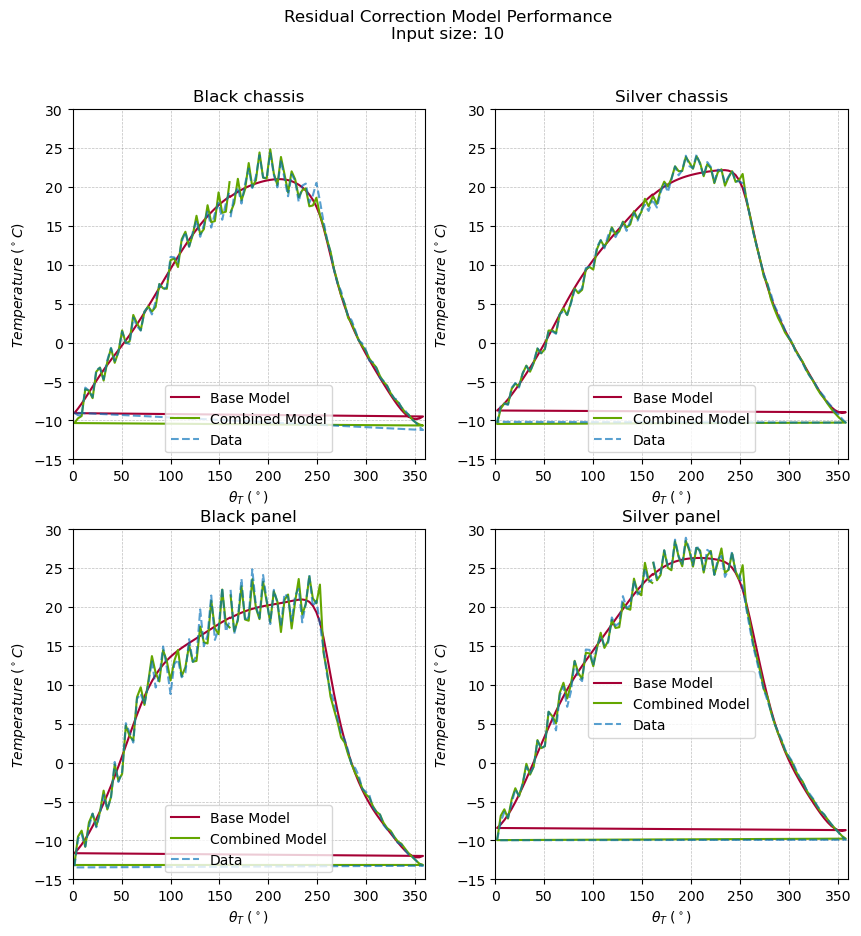

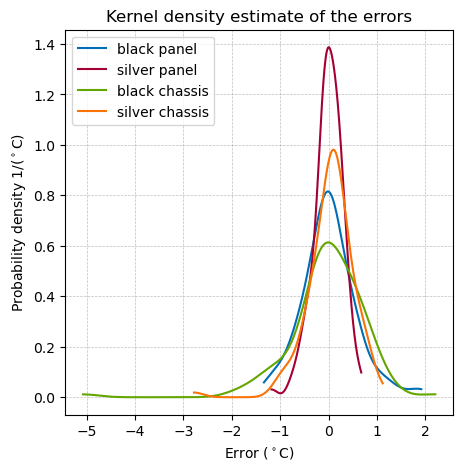

Black panel:
Mean: 0.01 degC Std: 0.56 degC (area: 0.98)
Silver panel:
Mean: -0.01 degC Std: 0.30 degC (area: 0.99)
Black chassis:
Mean: -0.03 degC Std: 0.81 degC (area: 0.99)
Silver chassis:
Mean: 0.04 degC Std: 0.49 degC (area: 0.99)


Probability of error within 1 degC:
Black panel: 0.90
Silver panel: 0.98
Black chassis: 0.83
Silver chassis: 0.95


In [20]:
y_pred_res = model_res_3.predict(x_test_97_res_3, verbose=0)
y_pred_combined = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res

plot_model(
    test_97_df["theta_T"][13:],
    y_test_97[13:] * (max_temp - min_temp) + min_temp,
    y_pred_base[13:] * (max_temp - min_temp) + min_temp,
    y_pred_combined[13:],
    plt_title="Residual Correction Model Performance\nInput size: 10",
    labels=["Data", "Base Model", "Combined Model"],
)
y_res = y_test_97 * (max_temp - min_temp) + min_temp - y_pred_combined

kde(y_res)

In [21]:
# Checking the ability of the networks to predict anomalies
anomaly_df = create_artificial_anomaly(
    97,
    anomaly_black_chassis=True,
    anomaly_silver_chassis=True,
)

base_df, x_base, y_base = window_data_base(anomaly_df, 97, return_numpy=True, check_continuity=False)
res_df_1, x_res_1, y_res_1 = window_data_res_1(anomaly_df, 97, return_numpy=True, check_continuity=False)
res_df_2, x_res_2, y_res_2 = window_data_res_2(anomaly_df, 97, return_numpy=True, check_continuity=False)
res_df_3, x_res_3, y_res_3 = window_data_res_3(anomaly_df, 97, return_numpy=True, check_continuity=False)

y_pred_base = model_base.predict(x_base, verbose=0)
y_pred_res_1 = model_res_1.predict(x_res_1, verbose=0)
y_pred_res_2 = model_res_2.predict(x_res_2, verbose=0)
y_pred_res_3 = model_res_3.predict(x_res_3, verbose=0)

y_pred_combined_1 = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res_1
y_pred_combined_2 = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res_2
y_pred_combined_3 = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res_3


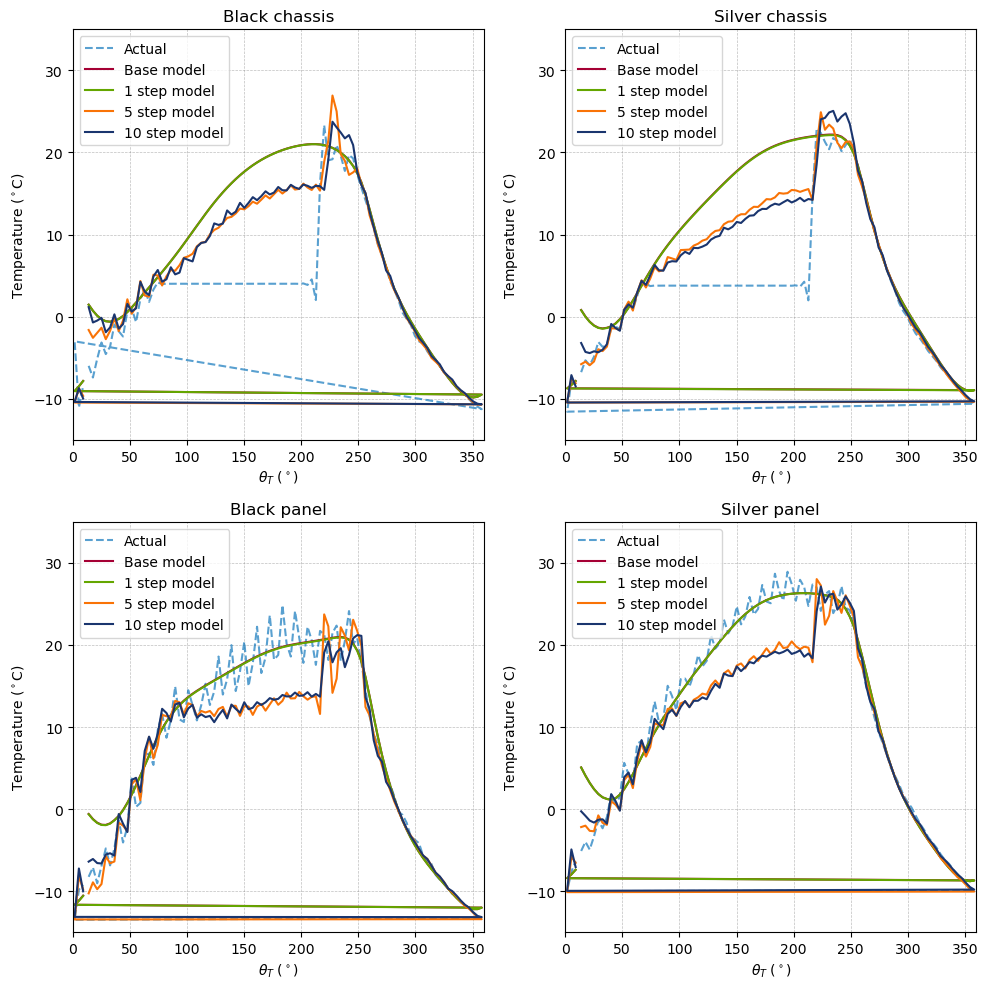

In [22]:
base_alpha = 0.65

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(
    base_df["theta_T"],
    y_base[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_1[:, 0],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_2[:, 0],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_3[:, 0],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Black chassis")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(
    base_df["theta_T"],
    y_base[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_1[:, 1],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_2[:, 1],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_3[:, 1],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Silver chassis")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(
    base_df["theta_T"],
    y_base[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_1[:, 2],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_2[:, 2],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_3[:, 2],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Black panel")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(
    base_df["theta_T"],
    y_base[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_1[:, 3],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_2[:, 3],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_3[:, 3],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Silver panel")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

In [23]:
def window_data_res_4(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["input black chassis temp"],
        ["input silver chassis temp"],
        ["input black panel temp"],
        ["input silver panel temp"],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "input black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "input silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "input black panel temp"] = df["black panel temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "input silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size - 1]
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna(how="all").reset_index(drop=True)

    x_pred = window_df.iloc[:, 1:window_size + 1].to_numpy(dtype=np.float64)
    x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
    y_pred = model_base.predict(x_pred, verbose=0)

    window_df["predicted black chassis temp"] = y_pred[:, 0]
    window_df["predicted silver chassis temp"] = y_pred[:, 1]
    window_df["predicted black panel temp"] = y_pred[:, 2]
    window_df["predicted silver panel temp"] = y_pred[:, 3]

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 9), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["predicted black chassis temp"]
            x_data[i, 2] = row["predicted silver chassis temp"]
            x_data[i, 3] = row["predicted black panel temp"]
            x_data[i, 4] = row["predicted silver panel temp"]
            x_data[i, 5] = row["input black chassis temp"]
            x_data[i, 6] = row["input silver chassis temp"]
            x_data[i, 7] = row["input black panel temp"]
            x_data[i, 8] = row["input silver panel temp"]

            y_data[i, 0] = ((row["black chassis temp"] - row["predicted black chassis temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 1] = ((row["silver chassis temp"] - row["predicted silver chassis temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 2] = ((row["black panel temp"] - row["predicted black panel temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 3] = ((row["silver panel temp"] - row["predicted silver panel temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)

        return window_df, x_data, y_data

    return window_df


Epoch 1/5000
11/11 [==============================] - 1s 22ms/step - loss: 0.2045 - mean_absolute_error: 0.4327 - val_loss: 0.2079 - val_mean_absolute_error: 0.4381
Epoch 2/5000
11/11 [==============================] - 0s 7ms/step - loss: 0.1765 - mean_absolute_error: 0.3988 - val_loss: 0.1819 - val_mean_absolute_error: 0.4051
Epoch 3/5000
11/11 [==============================] - 0s 7ms/step - loss: 0.1532 - mean_absolute_error: 0.3679 - val_loss: 0.1565 - val_mean_absolute_error: 0.3700
Epoch 4/5000
11/11 [==============================] - 0s 8ms/step - loss: 0.1307 - mean_absolute_error: 0.3345 - val_loss: 0.1326 - val_mean_absolute_error: 0.3338
Epoch 5/5000
11/11 [==============================] - 0s 8ms/step - loss: 0.1091 - mean_absolute_error: 0.2992 - val_loss: 0.1075 - val_mean_absolute_error: 0.2959
Epoch 6/5000
11/11 [==============================] - 0s 7ms/step - loss: 0.0870 - mean_absolute_error: 0.2623 - val_loss: 0.0856 - val_mean_absolute_error: 0.2603
Epoch 7/5000
11

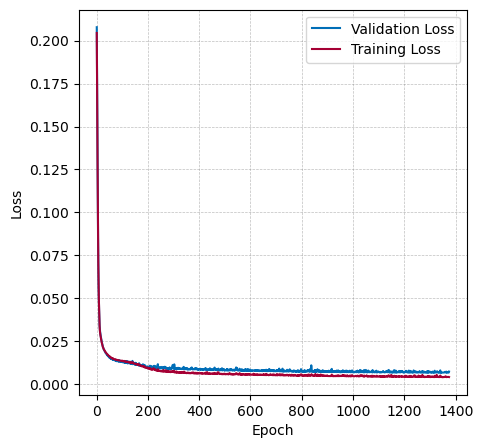

In [24]:
train_97_res_df_4, x_train_97_res_4, y_train_97_res_4 = window_data_res_4(train_norm_df, 97, return_numpy=True, check_continuity=True)
test_97_res_df_4, x_test_97_res_4, y_test_97_res_4 = window_data_res_4(test_norm_df, 97, return_numpy=True, check_continuity=True)

# Create residual correction model
model_res_4 = tf.keras.Sequential()
model_res_4.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(9,)))
model_res_4.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_4.add(tf.keras.layers.Dense(4, activation="linear"))

model_res_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_4.fit(
    x_train_97_res_4,
    y_train_97_res_4,
    epochs=5000,
    validation_data=(x_test_97_res_4, y_test_97_res_4),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

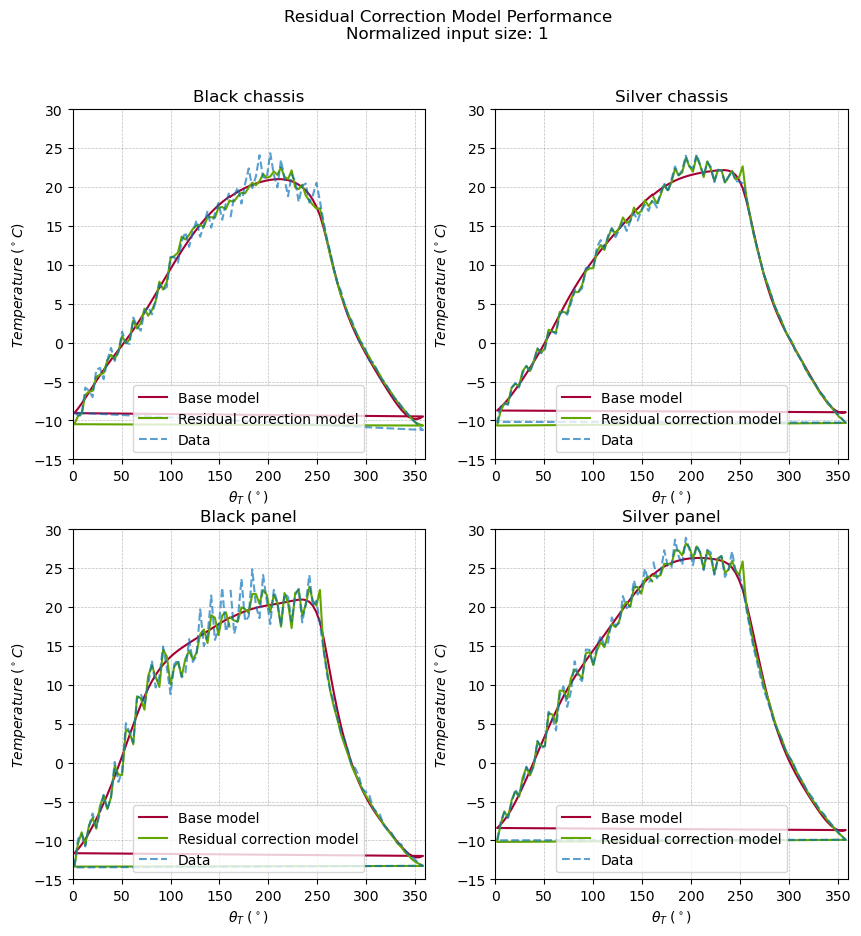

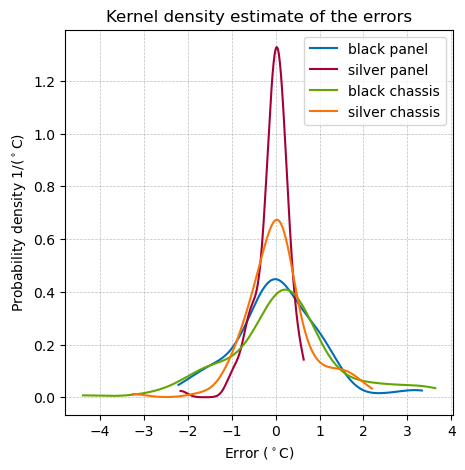

Black panel:
Mean: 0.06 degC Std: 1.01 degC (area: 0.97)
Silver panel:
Mean: -0.08 degC Std: 0.39 degC (area: 0.98)
Black chassis:
Mean: 0.16 degC Std: 1.31 degC (area: 0.98)
Silver chassis:
Mean: 0.06 degC Std: 0.76 degC (area: 0.99)


Probability of error within 1 degC:
Black panel: 0.69
Silver panel: 0.96
Black chassis: 0.61
Silver chassis: 0.81


In [25]:
y_pred_base = model_base.predict(x_test_97, verbose=0)
y_pred_res = model_res_4.predict(x_test_97_res_4, verbose=0)
y_pred_combined = y_pred_base * (max_temp - min_temp) + min_temp + (y_pred_res * (max_temp_res - min_temp_res) + min_temp_res)

plot_model(
    test_97_df["theta_T"][13:],
    y_test_97[13:] * (max_temp - min_temp) + min_temp,
    y_pred_base[13:] * (max_temp - min_temp) + min_temp,
    y_pred_combined[13:],
    plt_title="Residual Correction Model Performance\nNormalized input size: 1",
    labels=["Data", "Base model", "Residual correction model"],
)

y_res = y_test_97 * (max_temp - min_temp) + min_temp - y_pred_combined

kde(y_res)

In [26]:
def window_data_res_5(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["input black chassis temp " + str(i) for i in range(5)],
        ["input silver chassis temp " + str(i) for i in range(5)],
        ["input black panel temp " + str(i) for i in range(5)],
        ["input silver panel temp " + str(i) for i in range(5)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "input black chassis temp 0":"input black chassis temp 4"] = df["black chassis temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input silver chassis temp 0":"input silver chassis temp 4"] = df["silver chassis temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input black panel temp 0":"input black panel temp 4"] = df["black panel temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "input silver panel temp 0":"input silver panel temp 4"] = df["silver panel temperature (deg C)"][i + window_size - 5:i + window_size].values
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna(how="all").reset_index(drop=True)

    x_pred = window_df.iloc[:, 1:window_size + 1].to_numpy(dtype=np.float64)
    x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
    y_pred = model_base.predict(x_pred, verbose=0)

    window_df["predicted black chassis temp"] = y_pred[:, 0]
    window_df["predicted silver chassis temp"] = y_pred[:, 1]
    window_df["predicted black panel temp"] = y_pred[:, 2]
    window_df["predicted silver panel temp"] = y_pred[:, 3]

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 25), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["predicted black chassis temp"]
            x_data[i, 2] = row["predicted silver chassis temp"]
            x_data[i, 3] = row["predicted black panel temp"]
            x_data[i, 4] = row["predicted silver panel temp"]
            x_data[i, 5:10] = row["input black chassis temp 0":"input black chassis temp 4"].values
            x_data[i, 10:15] = row["input silver chassis temp 0":"input silver chassis temp 4"].values
            x_data[i, 15:20] = row["input black panel temp 0":"input black panel temp 4"].values
            x_data[i, 20:25] = row["input silver panel temp 0":"input silver panel temp 4"].values

            y_data[i, 0] = ((row["black chassis temp"] - row["predicted black chassis temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 1] = ((row["silver chassis temp"] - row["predicted silver chassis temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 2] = ((row["black panel temp"] - row["predicted black panel temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 3] = ((row["silver panel temp"] - row["predicted silver panel temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)

        return window_df, x_data, y_data

    return window_df


Epoch 1/5000
11/11 [==============================] - 1s 24ms/step - loss: 0.2432 - mean_absolute_error: 0.4742 - val_loss: 0.2468 - val_mean_absolute_error: 0.4810
Epoch 2/5000
11/11 [==============================] - 0s 9ms/step - loss: 0.2164 - mean_absolute_error: 0.4460 - val_loss: 0.2301 - val_mean_absolute_error: 0.4632
Epoch 3/5000
11/11 [==============================] - 0s 9ms/step - loss: 0.2031 - mean_absolute_error: 0.4305 - val_loss: 0.2182 - val_mean_absolute_error: 0.4496
Epoch 4/5000
11/11 [==============================] - 0s 10ms/step - loss: 0.1939 - mean_absolute_error: 0.4186 - val_loss: 0.2089 - val_mean_absolute_error: 0.4376
Epoch 5/5000
11/11 [==============================] - 0s 10ms/step - loss: 0.1851 - mean_absolute_error: 0.4067 - val_loss: 0.1987 - val_mean_absolute_error: 0.4248
Epoch 6/5000
11/11 [==============================] - 0s 9ms/step - loss: 0.1754 - mean_absolute_error: 0.3939 - val_loss: 0.1873 - val_mean_absolute_error: 0.4102
Epoch 7/5000


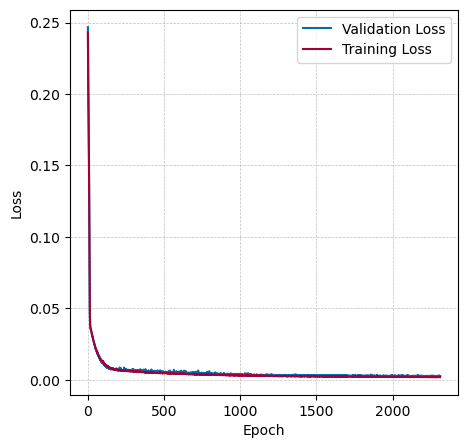

In [27]:
train_97_res_df_5, x_train_97_res_5, y_train_97_res_5 = window_data_res_5(train_norm_df, 97, return_numpy=True, check_continuity=True)
test_97_res_df_5, x_test_97_res_5, y_test_97_res_5 = window_data_res_5(test_norm_df, 97, return_numpy=True, check_continuity=True)

# Create residual correction model
model_res_5 = tf.keras.Sequential()
model_res_5.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(25,)))
model_res_5.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_5.add(tf.keras.layers.Dense(4, activation="linear"))

model_res_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

history_97_res = model_res_5.fit(
    x_train_97_res_5,
    y_train_97_res_5,
    epochs=5000,
    validation_data=(x_test_97_res_5, y_test_97_res_5),
    callbacks=[early_stopping],
)

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

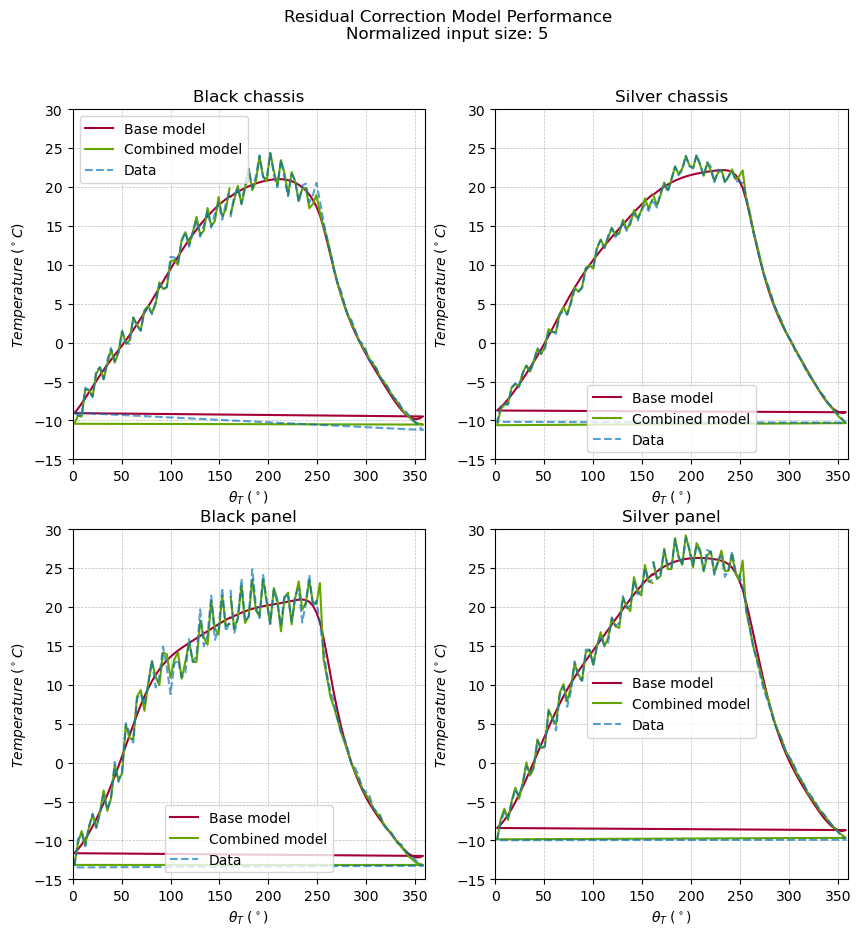

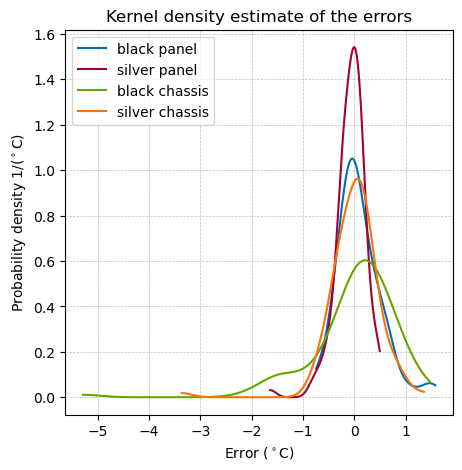

Black panel:
Mean: 0.09 degC Std: 0.43 degC (area: 0.97)
Silver panel:
Mean: -0.07 degC Std: 0.29 degC (area: 0.98)
Black chassis:
Mean: 0.00 degC Std: 0.86 degC (area: 0.98)
Silver chassis:
Mean: 0.01 degC Std: 0.50 degC (area: 0.99)


Probability of error within 1 degC:
Black panel: 0.94
Silver panel: 0.97
Black chassis: 0.79
Silver chassis: 0.96


In [28]:
y_pred_res = model_res_5.predict(x_test_97_res_5, verbose=0)
y_pred_combined = y_pred_base * (max_temp - min_temp) + min_temp + (y_pred_res * (max_temp_res - min_temp_res) + min_temp_res)

plot_model(
    test_97_df["theta_T"][13:],
    y_test_97[13:] * (max_temp - min_temp) + min_temp,
    y_pred_base[13:] * (max_temp - min_temp) + min_temp,
    y_pred_combined[13:],
    plt_title="Residual Correction Model Performance\nNormalized input size: 5",
    labels=["Data", "Base model", "Combined model"],
)

y_res = y_test_97 * (max_temp - min_temp) + min_temp - y_pred_combined

kde(y_res)

In [29]:
def window_data_res_6(df, window_size, return_numpy=False, check_continuity=True):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["predicted black chassis temp"],
        ["predicted silver chassis temp"],
        ["predicted black panel temp"],
        ["predicted silver panel temp"],
        ["input black chassis temp " + str(i) for i in range(10)],
        ["input silver chassis temp " + str(i) for i in range(10)],
        ["input black panel temp " + str(i) for i in range(10)],
        ["input silver panel temp " + str(i) for i in range(10)],
        ["black chassis temp"],
        ["silver chassis temp"],
        ["black panel temp"],
        ["silver panel temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(df) - window_size))

    for i in range(len(window_df)):
        if check_continuity:
            if df["time (jd)"][i + window_size] - df["time (jd)"][i] > (window_size + 1.5) / (24 * 60):
                continue
        
        window_df.iloc[i, 0] = df["theta_T (deg)"][i + window_size]
        window_df.iloc[i, 1:window_size + 1] = df.loc[i:i + window_size - 1, "illumination"]
        window_df.loc[i, "input black chassis temp 0":"input black chassis temp 9"] = df["black chassis temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "input silver chassis temp 0":"input silver chassis temp 9"] = df["silver chassis temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "input black panel temp 0":"input black panel temp 9"] = df["black panel temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "input silver panel temp 0":"input silver panel temp 9"] = df["silver panel temperature (deg C)"][i + window_size - 10:i + window_size].values
        window_df.loc[i, "black chassis temp"] = df["black chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver chassis temp"] = df["silver chassis temperature (deg C)"][i + window_size]
        window_df.loc[i, "black panel temp"] = df["black panel temperature (deg C)"][i + window_size]
        window_df.loc[i, "silver panel temp"] = df["silver panel temperature (deg C)"][i + window_size]

    window_df = window_df.dropna(how="all").reset_index(drop=True)

    x_pred = window_df.iloc[:, 1:window_size + 1].to_numpy(dtype=np.float64)
    x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[1], 1)
    y_pred = model_base.predict(x_pred, verbose=0)

    window_df["predicted black chassis temp"] = y_pred[:, 0]
    window_df["predicted silver chassis temp"] = y_pred[:, 1]
    window_df["predicted black panel temp"] = y_pred[:, 2]
    window_df["predicted silver panel temp"] = y_pred[:, 3]

    
    if return_numpy:
        x_data = np.empty(shape=(len(window_df), 45), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 4), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, 0] = row["illumination " + str(window_size - 1)]
            x_data[i, 1] = row["predicted black chassis temp"]
            x_data[i, 2] = row["predicted silver chassis temp"]
            x_data[i, 3] = row["predicted black panel temp"]
            x_data[i, 4] = row["predicted silver panel temp"]
            x_data[i, 5:15] = row["input black chassis temp 0":"input black chassis temp 9"].values
            x_data[i, 15:25] = row["input silver chassis temp 0":"input silver chassis temp 9"].values
            x_data[i, 25:35] = row["input black panel temp 0":"input black panel temp 9"].values
            x_data[i, 35:45] = row["input silver panel temp 0":"input silver panel temp 9"].values

            y_data[i, 0] = ((row["black chassis temp"] - row["predicted black chassis temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 1] = ((row["silver chassis temp"] - row["predicted silver chassis temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 2] = ((row["black panel temp"] - row["predicted black panel temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)
            y_data[i, 3] = ((row["silver panel temp"] - row["predicted silver panel temp"]) * (max_temp - min_temp) - min_temp_res) / (max_temp_res - min_temp_res)

        return window_df, x_data, y_data

    return window_df


Epoch 1/5000
11/11 [==============================] - 1s 29ms/step - loss: 0.2549 - mean_absolute_error: 0.4873 - val_loss: 0.2641 - val_mean_absolute_error: 0.4996
Epoch 2/5000
11/11 [==============================] - 0s 10ms/step - loss: 0.2314 - mean_absolute_error: 0.4635 - val_loss: 0.2455 - val_mean_absolute_error: 0.4813
Epoch 3/5000
11/11 [==============================] - 0s 9ms/step - loss: 0.2171 - mean_absolute_error: 0.4483 - val_loss: 0.2351 - val_mean_absolute_error: 0.4703
Epoch 4/5000
11/11 [==============================] - 0s 10ms/step - loss: 0.2095 - mean_absolute_error: 0.4395 - val_loss: 0.2261 - val_mean_absolute_error: 0.4603
Epoch 5/5000
11/11 [==============================] - 0s 10ms/step - loss: 0.2011 - mean_absolute_error: 0.4292 - val_loss: 0.2164 - val_mean_absolute_error: 0.4488
Epoch 6/5000
11/11 [==============================] - 0s 11ms/step - loss: 0.1921 - mean_absolute_error: 0.4174 - val_loss: 0.2058 - val_mean_absolute_error: 0.4354
Epoch 7/500

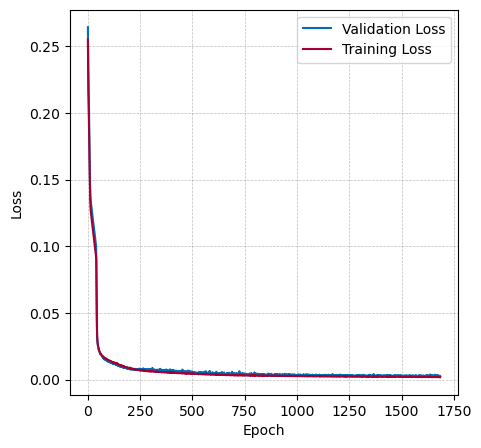

In [30]:
train_97_res_df_6, x_train_97_res_6, y_train_97_res_6 = window_data_res_6(train_norm_df, 97, return_numpy=True, check_continuity=True)
test_97_res_df_6, x_test_97_res_6, y_test_97_res_6 = window_data_res_6(test_norm_df, 97, return_numpy=True, check_continuity=True)

# Create residual correction model
model_res_6 = tf.keras.Sequential()
model_res_6.add(tf.keras.layers.Dense(256, activation="relu", input_shape=(45,)))
model_res_6.add(tf.keras.layers.Dense(256, activation="relu"))
model_res_6.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_6.add(tf.keras.layers.Dense(128, activation="relu"))
model_res_6.add(tf.keras.layers.Dense(64, activation="relu"))
model_res_6.add(tf.keras.layers.Dense(32, activation="relu"))
model_res_6.add(tf.keras.layers.Dense(16, activation="relu"))
model_res_6.add(tf.keras.layers.Dense(4, activation="linear"))

model_res_6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True
)

with tf.device("/GPU:0"):
    history_97_res = model_res_6.fit(
        x_train_97_res_6,
        y_train_97_res_6,
        epochs=5000,
        validation_data=(x_test_97_res_6, y_test_97_res_6),
        callbacks=[early_stopping],
    )

plt.figure(figsize=(5, 5))
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["val_loss"],
    color=plt_colors[0],
    label="Validation Loss",
)
plt.plot(
    np.linspace(1, len(history_97_res.history["loss"]), len(history_97_res.history["loss"])),
    history_97_res.history["loss"],
    color=plt_colors[1],
    label="Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

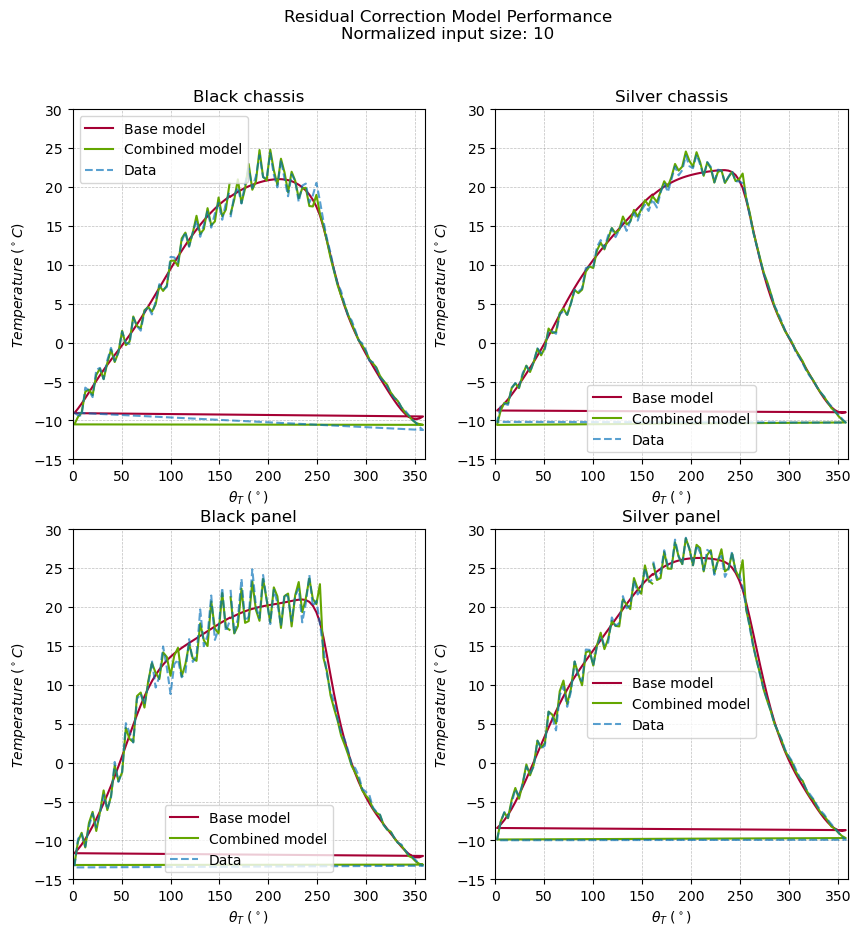

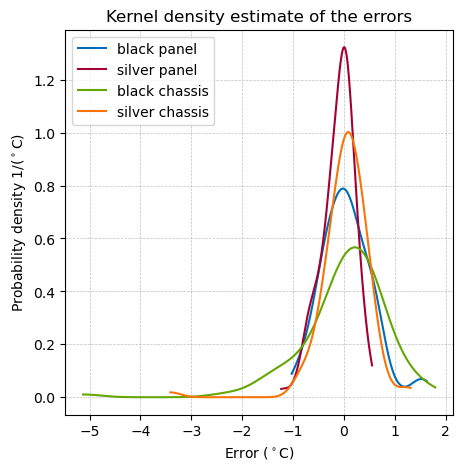

Black panel:
Mean: 0.06 degC Std: 0.51 degC (area: 0.97)
Silver panel:
Mean: -0.12 degC Std: 0.32 degC (area: 0.98)
Black chassis:
Mean: 0.01 degC Std: 0.88 degC (area: 0.99)
Silver chassis:
Mean: 0.03 degC Std: 0.50 degC (area: 0.99)


Probability of error within 1 degC:
Black panel: 0.94
Silver panel: 0.97
Black chassis: 0.78
Silver chassis: 0.96


In [31]:
y_pred_res = model_res_6.predict(x_test_97_res_6, verbose=0)
y_pred_combined = y_pred_base * (max_temp - min_temp) + min_temp + (y_pred_res * (max_temp_res - min_temp_res) + min_temp_res)

plot_model(
    test_97_df["theta_T"][13:],
    y_test_97[13:] * (max_temp - min_temp) + min_temp,
    y_pred_base[13:] * (max_temp - min_temp) + min_temp,
    y_pred_combined[13:],
    plt_title="Residual Correction Model Performance\nNormalized input size: 10",
    labels=["Data", "Base model", "Combined model"],
)

y_res = y_test_97 * (max_temp - min_temp) + min_temp - y_pred_combined
kde(y_res)

In [32]:
# Checking the ability of the networks to predict anomalies
anomaly_df = create_artificial_anomaly(
    97,
    anomaly_black_chassis=True,
    anomaly_silver_chassis=True,
)

base_df, x_base, y_base = window_data_base(anomaly_df, 97, return_numpy=True, check_continuity=False)
res_df_4, x_res_4, y_res_4 = window_data_res_4(anomaly_df, 97, return_numpy=True, check_continuity=False)
res_df_5, x_res_5, y_res_5 = window_data_res_5(anomaly_df, 97, return_numpy=True, check_continuity=False)
res_df_6, x_res_6, y_res_6 = window_data_res_6(anomaly_df, 97, return_numpy=True, check_continuity=False)

y_pred_base = model_base.predict(x_base, verbose=0)
y_pred_res_4 = model_res_4.predict(x_res_4, verbose=0) * (max_temp_res - min_temp_res) + min_temp_res
y_pred_res_5 = model_res_5.predict(x_res_5, verbose=0) * (max_temp_res - min_temp_res) + min_temp_res
y_pred_res_6 = model_res_6.predict(x_res_6, verbose=0) * (max_temp_res - min_temp_res) + min_temp_res

y_pred_combined_4 = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res_4
y_pred_combined_5 = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res_5
y_pred_combined_6 = y_pred_base * (max_temp - min_temp) + min_temp + y_pred_res_6


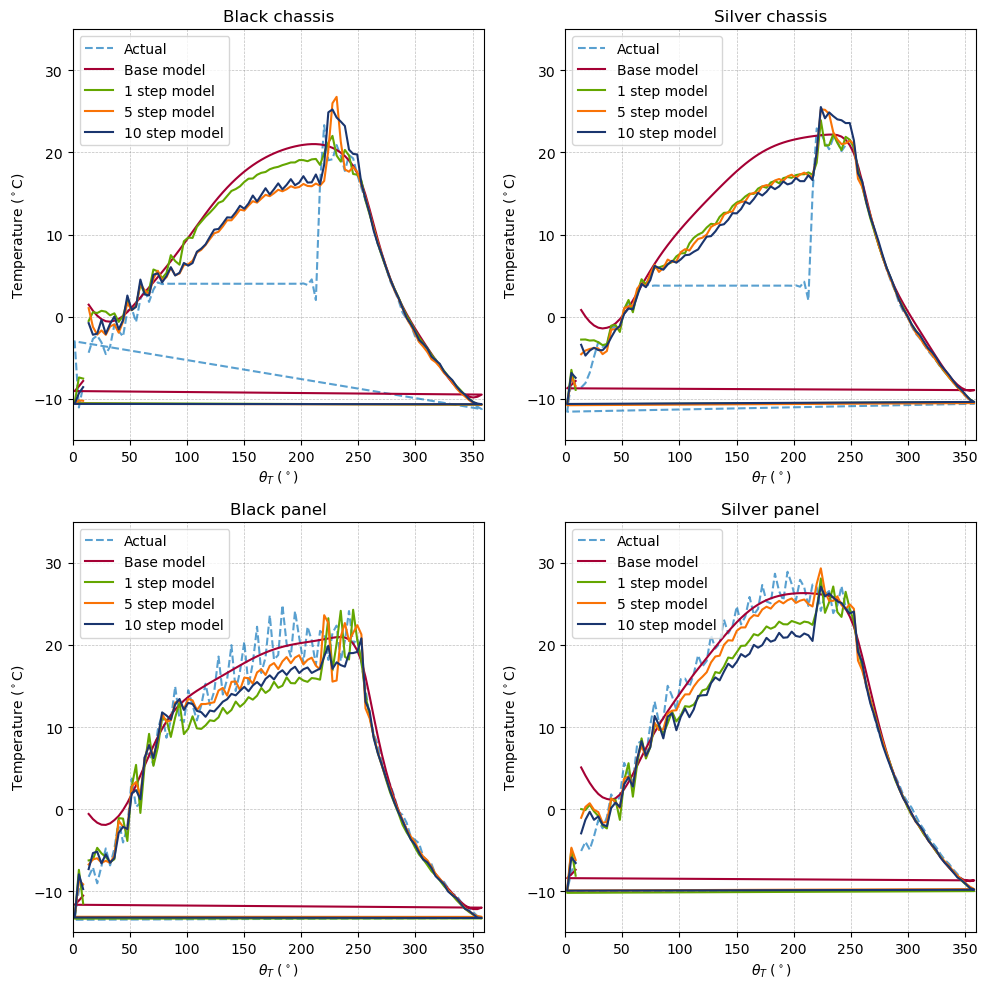

In [33]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(
    base_df["theta_T"],
    y_base[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 0] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_4[:, 0],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_5[:, 0],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_6[:, 0],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Black chassis")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(
    base_df["theta_T"],
    y_base[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 1] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_4[:, 1],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_5[:, 1],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_6[:, 1],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Silver chassis")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(
    base_df["theta_T"],
    y_base[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 2] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_4[:, 2],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_5[:, 2],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_6[:, 2],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Black panel")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(
    base_df["theta_T"],
    y_base[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[0],
    label="Actual",
    linestyle="dashed",
    alpha=base_alpha,
)
plt.plot(
    base_df["theta_T"],
    y_pred_base[:, 3] * (max_temp - min_temp) + min_temp,
    color=plt_colors[1],
    label="Base model",
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_4[:, 3],
    color=plt_colors[2],
    label="1 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_5[:, 3],
    color=plt_colors[3],
    label="5 step model"
)
plt.plot(
    base_df["theta_T"],
    y_pred_combined_6[:, 3],
    color=plt_colors[4],
    label="10 step model"
)
plt.xlabel(r"$\theta_T\;(^\circ)$")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.title("Silver panel")
plt.xlim(0, 360)
plt.ylim(-15, 35)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
plt.close()